[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/color_raw_to_rgb.ipynb)

# Convert RGB to RAW



## Download necessary files and libraries

In [ ]:
%%capture
!pip install kornia
!pip install rawpy
!wget -q --show-progress --no-check-certificate 'https://docs.google.com/uc?export=download&id=1nSM_FYJ7i9-_57ecPY5sCG2s8zt9dRhF' -O raw.dng

## Import necessary libraries

In [ ]:
import kornia
import matplotlib.pyplot as plt
import numpy as np
import rawpy
import torch

## Prepare the raw file through rawpy

In [ ]:
path = "raw.dng"
raw = rawpy.imread(path)
cfa = "".join([chr(raw.color_desc[i]) for i in raw.raw_pattern.flatten()])

# Figure out which cfa we are using by looking at the component order from rawpy
# if we do this directly from a camera this would of course be known ahead
# of time
if cfa == "GRBG":
    korniacfa = kornia.color.CFA.GB
elif cfa == "GBRG":
    korniacfa = kornia.color.CFA.GR
elif cfa == "BGGR":
    korniacfa = kornia.color.CFA.RG
elif cfa == "RGGB":
    korniacfa = kornia.color.CFA.BG

# This is a GB file i.e. top left pixel is Green follow by Red (and the pair
# starting at (1,1) is Green, Blue)
print(cfa)
print(korniacfa)

GRBG
CFA.GB


## Get the data into kornia by doing the conversion


In [ ]:
# We find the data inside raw.raw_image
rawdata = raw.raw_image
# white level gives maximum value for a pixel
rawtensor = torch.Tensor(rawdata.astype(np.float32) / raw.white_level).reshape(
    1, 1, raw.raw_image.shape[0], raw.raw_image.shape[1]
)
rgbtensor = kornia.color.raw.raw_to_rgb(rawtensor, korniacfa)

## Visualize


<matplotlib.image.AxesImage>

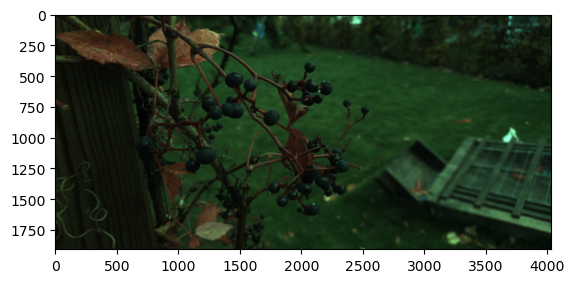

In [ ]:
npimg = np.moveaxis(np.squeeze((rgbtensor * 255.0).numpy().astype(np.uint8)), 0, 2)
plt.figure()

# Show the image
# Colors will look a little funky because they need to be balanced properly, but
# the leaves are supposed to be redm berries blue and grass green
plt.imshow(npimg)

## Gotchas: Rotation gives a different cfa

<matplotlib.image.AxesImage>

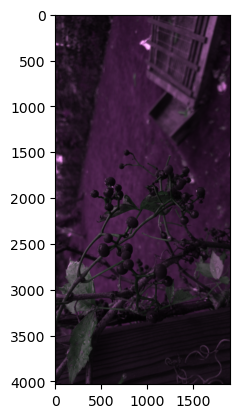

In [ ]:
# if we do a pipeline were we first rotate the image, it will end up with a
# different cfa that isn't possible to describe since we are assuming all red
# samples are on t.he same row while they would not be rotated
rgbtensor = kornia.color.raw.raw_to_rgb(torch.rot90(rawtensor, 1, [2, 3]), korniacfa)
npimg = np.moveaxis(np.squeeze((rgbtensor * 255.0).numpy().astype(np.uint8)), 0, 2)
plt.figure()
plt.imshow(npimg)

<matplotlib.image.AxesImage>

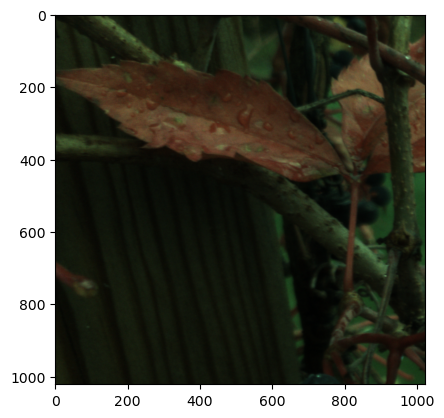

In [ ]:
# If we crop, we can adjust for this by using a different cfa
rgbtensor = kornia.color.raw.raw_to_rgb(rawtensor[:, :, 1:1023, 1:1023], kornia.color.raw.CFA.GR)
npimg = np.moveaxis(np.squeeze((rgbtensor * 255.0).numpy().astype(np.uint8)), 0, 2)
plt.figure()
plt.imshow(npimg)